## Breast Cancer Detection using various Machine Learning models

### Import Needed Libraries and Packages 

In [48]:
# importing various libraries needed 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


# import libraries needed for ML models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score #  ,plot_confusion_matrix,
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, balanced_accuracy_score


In [2]:
import warnings
warnings.filterwarnings('ignore')

### User Defined Functions needed to use repetively when comparing the metrics for each model

In [3]:
# Function to return the accuracy metrics
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),
             "train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

# Function to calculate the average correlation between predictors
def get_correlation(X_test, y_test,models):
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr

# Function to determine the error between the predicted and the test target
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

# Function to determine the Accuracy for the Train and Test data
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

### Load the dataset of results of the FNA of masses 

In [4]:
df = pd.read_csv('data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Brief Exploratory Data Analysis

In [5]:
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [6]:
# Check for columns with null entries
df.columns[df.isna().any()]

Index(['Unnamed: 32'], dtype='object')

<Axes: >

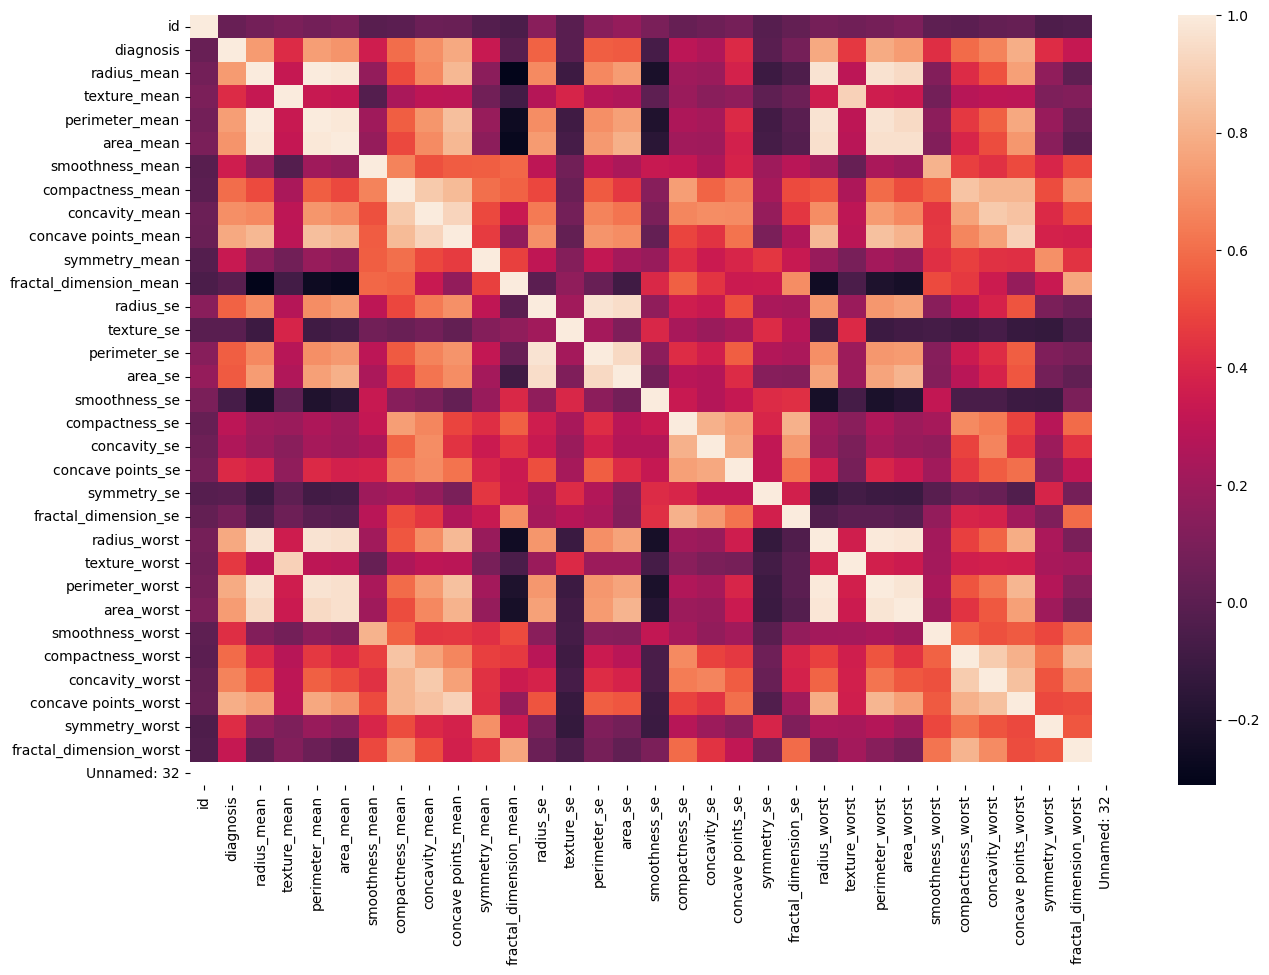

In [9]:
# Review the correlation Matrix to identify any highly correlated features
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df.corr())

It looks like perimeter and area are highly correlated features

### Data Pre-Processing

In [7]:
# Diagnosis is the only object column and our target column, lets view the entries
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [8]:
# Convert the diagnosis column from B for Benign to 0 and M for Malignant to 1
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})
df['diagnosis'].value_counts()
y = df['diagnosis'].astype('int')

diagnosis
0    357
1    212
Name: count, dtype: int64

In [14]:
y.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

#### Feature columns X_mean is for only the mean columns while X_all is for all numeric columns

In [11]:
X_mean = df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
X_all = df.drop(['id','diagnosis'],axis=1)


## Split the Dataset into Training and Testing sets

In [17]:
# Split 80% as training dataset
# and 20% as testing dataset in a stratified manner 
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, stratify=y, random_state = 11)

## Comparing different ML Models (Logistic Regression, KNN, RandomForest) to determine best model
#### Defining functions to set the hyperparameters to tune for the GridSearch for each model so that we can obtain the best parameters to use to fit the model to the data


In [34]:
rs = 111 # Ramdom State variable
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter':[100, 500, 1000, 10000]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a KNN model
def grid_search_knn(X_train, y_train):
    params_grid = {
    'n_neighbors': [3, 5, 7, 9],        # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting strategy
    'p': [1, 2]                          # Power parameter for Minkowski distance
    }
    knn_model = KNeighborsClassifier(n_neighbors=2)
    grid_search = GridSearchCV(estimator = knn_model, 
                           param_grid = params_grid, 
                           cv = 5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

## Logistic Regression Best fit

In [ ]:
# Determine the best hyperparameters to use for Logistic Regression for the data
lr_best_params = grid_search_lr(X_train, y_train)
lr_best_params

In [36]:
l2_model = LogisticRegression(random_state=rs, penalty='l1', solver='liblinear', max_iter=100)
l2_model.fit(X_train, y_train)
l2_preds = l2_model.predict(X_test)

In [39]:
evaluate_metrics(y_test, l2_preds)

{'accuracy': 0.9210526315789473,
 'recall': array([0.95833333, 0.85714286]),
 'precision': array([0.92      , 0.92307692]),
 'f1score': array([0.93877551, 0.88888889])}

## K Nearest Neighbors

In [40]:
knn_best_params = grid_search_knn(X_train, y_train)
knn_best_params

{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

In [41]:
# Define a KNN classifier with the hypertuned parameters
knn_model = KNeighborsClassifier(n_neighbors=7, p=1, weights='uniform')
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

In [42]:
evaluate_metrics(y_test, knn_preds)

{'accuracy': 0.9035087719298246,
 'recall': array([0.97222222, 0.78571429]),
 'precision': array([0.88607595, 0.94285714]),
 'f1score': array([0.92715232, 0.85714286])}

In [29]:
rf_best_params = grid_search_rf(X_train, y_train)
rf_best_params

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'class_weight': {0: 0.2, 1: 0.8},
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [44]:
## Random Forest Model
rf_model = RandomForestClassifier( n_estimators=50, max_depth = 5, min_samples_split=2, max_features=0.2, random_state=rs)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, max_features=0.2, n_estimators=50,
                       random_state=111)

In [49]:
print(get_accuracy(X_train, X_test, y_train, y_test, rf_model))

{'test Accuracy': 0.9385964912280702, 'train Accuracy': 0.9824175824175824}
